In [16]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

!pip install vecstack

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from vecstack import stacking
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from time import time

from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as st
from scipy.special import boxcox1p

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


Reading Data from File

In [17]:
train_data = pd.read_csv(r'/gdrive/My Drive/Colab Notebooks/Linear_Regression/train.csv')
test_data = pd.read_csv(r'/gdrive/My Drive/Colab Notebooks/Linear_Regression/test.csv')

In [18]:
test_data.shape

(1459, 80)

In [19]:
train_data.shape

(1460, 81)

In [20]:
train_data.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [21]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [22]:
ytrain = train_data['SalePrice']
id = test_data['Id']
len_train = train_data.shape[0]
len_test = test_data.shape[0]

Combining the Train and Test data

In [48]:
total_Data = pd.concat((train_data,test_data), sort=True).reset_index(drop = True)
total_Data['Dataset'] = np.repeat(['Train', 'Test'], [len_train, len_test], axis=0)
total_Data.drop('Id', axis=1,inplace=True)

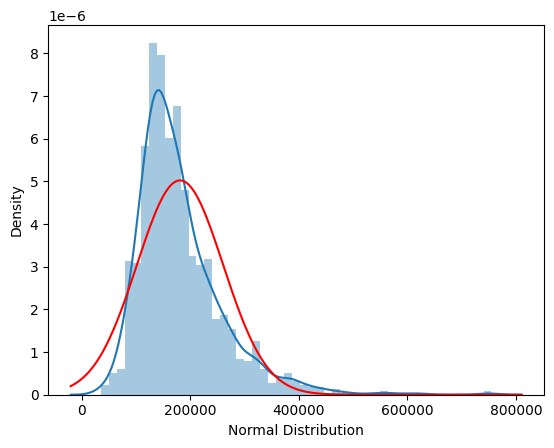

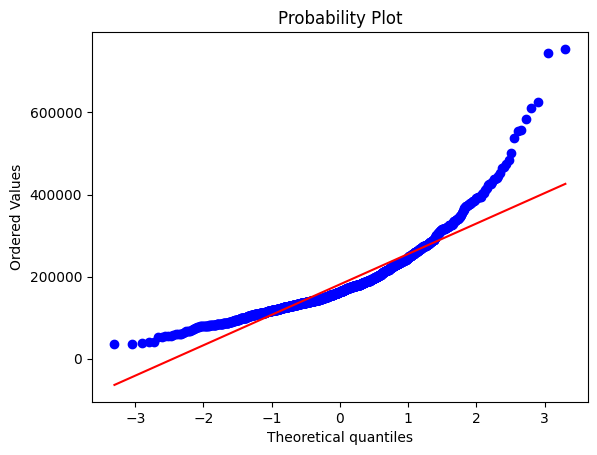

In [24]:
sns.distplot(total_Data['SalePrice'][~total_Data['SalePrice'].isnull()], axlabel="Normal Distribution", fit=st.norm, fit_kws={"color":"red"})
plt.show()

st.probplot(total_Data['SalePrice'][~total_Data['SalePrice'].isnull()], plot=plt)
plt.show()

Target Variable Transformation

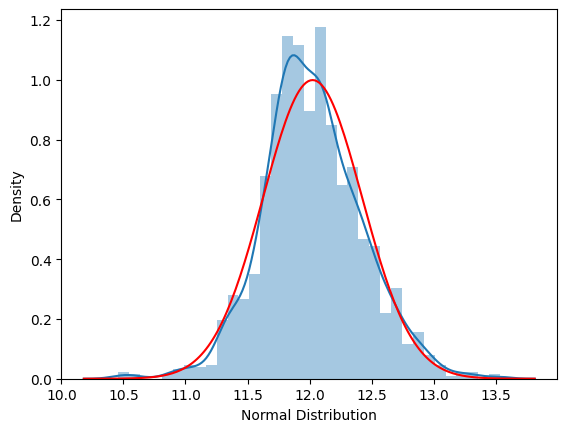

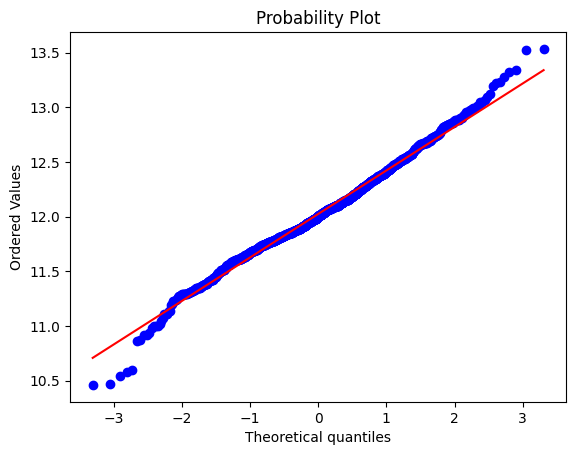

In [25]:
total_Data['SalePrice'] = np.log1p(total_Data['SalePrice'])

sns.distplot(total_Data['SalePrice'][~total_Data['SalePrice'].isnull()], axlabel="Normal Distribution", fit=st.norm, fit_kws={"color":"red"})
plt.show()

st.probplot(total_Data['SalePrice'][~total_Data['SalePrice'].isnull()], plot=plt)
plt.show()

## **Handling Missing Values**

In [26]:
# Nan values for this categorical variable means that there is no Garage or Pool or Fence etc.
col = ['PoolQC','MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for var in col:
    total_Data[var].replace(np.nan, 'None', regex=True, inplace=True)

In [27]:
# as there is No Garage there will not be any cars or area etc.
Garage_nums = ['GarageYrBlt', 'GarageCars', 'GarageArea']
for i in Garage_nums:
    total_Data[i].replace(np.nan, 0, regex = True, inplace = True)

In [28]:
#similarly for no basement
basement_cols = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for j in basement_cols:
    total_Data[j].replace(np.nan, 'None', regex=True, inplace=True)

In [29]:
basement_nums = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for i in basement_nums:
    total_Data[i].replace(np.nan, 0, regex = True, inplace = True)

In [30]:
total_Data['MasVnrType'].replace(np.nan, 'None', regex=True, inplace=True)
total_Data['MasVnrArea'].replace(np.nan, 0, regex=True, inplace=True)
total_Data['Functional'].replace(np.nan, 'Typical', regex=True, inplace=True)

In [31]:
from collections import Counter

In [32]:
Counter(total_Data['Utilities'])

Counter({'AllPub': 2916, 'NoSeWa': 1, nan: 2})

In [33]:
total_Data.drop('Utilities',axis = 1,inplace= True)

In [34]:
#missing values of below mentioned categories are replaced with the most frequently occuring category
col_missing_data = ['MSZoning','Electrical','Exterior1st','Exterior2nd','KitchenQual','SaleType']
for i in col_missing_data:
  print(str(i)+ ' : '+ str(Counter(total_Data[i])))
  total_Data[i].replace(np.nan, total_Data[i].mode()[0], regex=True, inplace=True)
  print(str(i)+ ' : '+ str(Counter(total_Data[i])))

MSZoning : Counter({'RL': 2265, 'RM': 460, 'FV': 139, 'RH': 26, 'C (all)': 25, nan: 4})
MSZoning : Counter({'RL': 2269, 'RM': 460, 'FV': 139, 'RH': 26, 'C (all)': 25})
Electrical : Counter({'SBrkr': 2671, 'FuseA': 188, 'FuseF': 50, 'FuseP': 8, 'Mix': 1, nan: 1})
Electrical : Counter({'SBrkr': 2672, 'FuseA': 188, 'FuseF': 50, 'FuseP': 8, 'Mix': 1})
Exterior1st : Counter({'VinylSd': 1025, 'MetalSd': 450, 'HdBoard': 442, 'Wd Sdng': 411, 'Plywood': 221, 'CemntBd': 126, 'BrkFace': 87, 'WdShing': 56, 'AsbShng': 44, 'Stucco': 43, 'BrkComm': 6, 'AsphShn': 2, 'Stone': 2, 'CBlock': 2, 'ImStucc': 1, nan: 1})
Exterior1st : Counter({'VinylSd': 1026, 'MetalSd': 450, 'HdBoard': 442, 'Wd Sdng': 411, 'Plywood': 221, 'CemntBd': 126, 'BrkFace': 87, 'WdShing': 56, 'AsbShng': 44, 'Stucco': 43, 'BrkComm': 6, 'AsphShn': 2, 'Stone': 2, 'CBlock': 2, 'ImStucc': 1})
Exterior2nd : Counter({'VinylSd': 1014, 'MetalSd': 447, 'HdBoard': 406, 'Wd Sdng': 391, 'Plywood': 270, 'CmentBd': 126, 'Wd Shng': 81, 'BrkFace': 47

In [35]:
total_Data['TotalArea'] = total_Data['TotalBsmtSF'] + total_Data['1stFlrSF'] + total_Data['2ndFlrSF']

In [36]:
total_Data['TotalBath'] = total_Data['BsmtFullBath'] + (total_Data['BsmtHalfBath']*0.5) + total_Data['FullBath'] + (total_Data['HalfBath']*0.5)

## **Model to Predicting the missing values of LotFrontage**

In [37]:
train_LotFrontage = total_Data[~total_Data.LotFrontage.isnull()]
test_LotFrontage = total_Data[total_Data.LotFrontage.isnull()]

<Axes: >

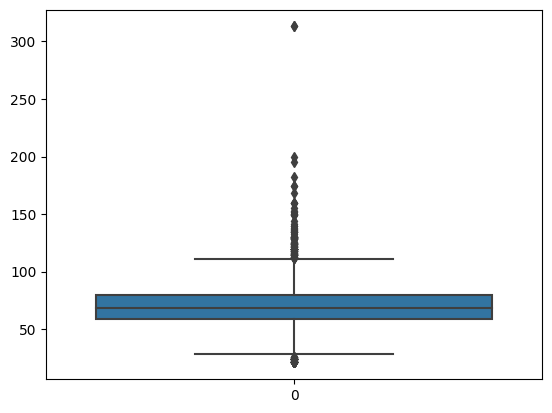

In [38]:
sns.boxplot(train_LotFrontage['LotFrontage'])

Outlier Detection & Removal

In [39]:
def outlier_detection(data):
    Q1, Q3 = np.percentile(data, [25,75])
    IQR = Q3-Q1
    lower_cutoff = Q1 - (IQR * 1.5)
    upper_cutoff = Q3 + (IQR * 1.5)
    outliers = (data > Q3+1.5*IQR) | (data < Q1-1.5*IQR)
    return outliers


In [40]:
train_LotFrontage_no_outliers = train_LotFrontage[~outlier_detection(train_LotFrontage.LotFrontage)]

In [41]:
X = train_LotFrontage_no_outliers.drop(['SalePrice'],axis = 1)
y = train_LotFrontage_no_outliers['LotFrontage']
X.isnull().sum().sort_values(ascending=False)

1stFlrSF        0
HeatingQC       0
Neighborhood    0
MoSold          0
MiscVal         0
               ..
FireplaceQu     0
Fence           0
Exterior2nd     0
Exterior1st     0
TotalBath       0
Length: 81, dtype: int64

In [42]:
X = pd.get_dummies(X)
transformer = StandardScaler().fit(X)
X = transformer.transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

clf = svm.SVR(kernel='rbf', C=100, gamma=0.001)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [45]:
print('Mean Absolute Error:  %.3f' % mean_absolute_error(y_test, preds))


Mean Absolute Error:  1.581


In [46]:
test_LotFrontage.isnull().sum().sort_values(ascending=False)

LotFrontage     486
SalePrice       227
1stFlrSF          0
MSSubClass        0
Neighborhood      0
               ... 
FireplaceQu       0
Fence             0
Exterior2nd       0
Exterior1st       0
TotalBath         0
Length: 82, dtype: int64

In [47]:
new_train = train_LotFrontage_no_outliers.copy()     #training data without outliers
full_data= new_train.append(test_LotFrontage)        #full data (train + Test) without outliers
y = full_data['LotFrontage']                         #seperate the label
#considering those variables that have more impact on LotFrontage
full_data = full_data[['MSZoning', 'Alley', 'LotArea', 'LotShape', 'LotConfig', 'Neighborhood', 'GarageType', 'GarageCars', 'GarageArea']]

In [ ]:
full_data = pd.get_dummies(full_data)                #One_Hot_Encoding
new_X_train = full_data[~y.isnull()]                 #X_train should have all the 'y'- not null data and x_test should have all the rows where 'y' is null
new_X_test = full_data[y.isnull()]
new_y_train = y[~y.isnull()]                         #similarly with y

In [ ]:
transformer = StandardScaler().fit(new_X_train)
new_X_train = transformer.transform(new_X_train)
new_X_test = transformer.transform(new_X_test)

In [ ]:
model = svm.SVR(kernel='rbf', C=100, gamma=0.001)
model.fit(new_X_train, new_y_train)
pred_LotFrontage = model.predict(new_X_test)

In [ ]:
total_Data.LotFrontage[total_Data.LotFrontage.isnull()] = pred_LotFrontage

In [ ]:
total_Data.isnull().sum().sort_values(ascending=False)

SalePrice       1459
1stFlrSF           0
MSSubClass         0
Neighborhood       0
MoSold             0
                ... 
FireplaceQu        0
Fence              0
Exterior2nd        0
Exterior1st        0
TotalBath          0
Length: 82, dtype: int64

OneHotEncoding

In [ ]:
total_Data = pd.get_dummies(total_Data)
print(total_Data.shape)
total_Data.head(3)

(2919, 306)


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Dataset_Test,Dataset_Train
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,...,0,0,0,0,0,1,0,1,0,1
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,...,0,0,0,0,0,1,0,1,0,1
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,0,...,0,0,0,0,0,1,0,1,0,1


# **Seperate Train and Test Data**

In [ ]:
total_Data['SalePrice'] = ytrain

In [ ]:
main_ytrain = total_Data['SalePrice'][~total_Data['SalePrice'].isnull()]
main_Xtrain = total_Data[total_Data['Dataset_Train'] == 1].drop(['Dataset_Train', 'Dataset_Test', 'SalePrice'], axis=1)
main_Xtest = total_Data[total_Data['Dataset_Test'] == 1].drop(['Dataset_Train','Dataset_Test', 'SalePrice'], axis = 1)

In [ ]:
main_ytrain.head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

In [ ]:
main_ytrain.shape

(1460,)

# **Runnig different regression methods**

**DecisionTreeRegressor()**

In [ ]:
dt = DecisionTreeRegressor()
param_grid = {
    'max_depth': [5, 7, 10,15],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [3, 5, 10]
}
dt = RandomizedSearchCV(dt, param_grid,cv=5)
dt.fit(main_Xtrain,main_ytrain)
dt = dt.best_estimator_
y_pred1 = dt.predict(main_Xtrain)

print("RMSE (training) for Decision Tree:{0:10f}".format(mean_squared_error(main_ytrain,y_pred1)))

RMSE (training) for Decision Tree:730222682.898074


In [ ]:
#Save predictions
df_DT=pd.DataFrame()
df_DT['SalePrice'] = dt.predict(main_Xtest)

In [ ]:
result = pd.concat([id,df_DT['SalePrice']],axis=1)
result

,Id,SalePrice
0,1461,122282.008696
1,1462,161395.000000
2,1463,201237.647059
3,1464,178293.218182
4,1465,225206.500000
...,...,...
1454,2915,80226.666667
1455,2916,80226.666667
1456,2917,159661.666667
1457,2918,119646.875000


In [ ]:
result.to_csv('/gdrive/My Drive/Colab Notebooks/Linear_Regression/result_dt_rsearch.csv',index=None)

**GradientBoostingRegressor()**

In [ ]:
abc =GradientBoostingRegressor()
parms = {'n_estimators': [50, 80, 100],
    'learning_rate': [ 0.1, 0.2],
    'max_depth': [5, 7, 10, 15]}
grid_gb = GridSearchCV(abc,parms, cv=5, scoring='neg_mean_squared_error')
grid_gb.fit(main_Xtrain,main_ytrain)
model_gb = grid_gb.best_estimator_
abc_predict_Train = model_gb.predict(main_Xtest)
gb=pd.DataFrame()
gb['SalePrice']=abc_predict_Train
gb['SalePrice']

0       132137.737539
1       166734.129389
2       182140.935712
3       188810.758936
4       190402.568347
            ...      
1454     82961.227740
1455     79728.015785
1456    162698.566701
1457    118629.476743
1458    216546.054591
Name: SalePrice, Length: 1459, dtype: float64

In [ ]:
result = pd.concat([id,gb['SalePrice']],axis=1)
result.to_csv('/gdrive/My Drive/Colab Notebooks/Linear_Regression/result_gb1.csv',index=None)

**RandomForestRegressor()**

In [ ]:
RFR = RandomForestRegressor()
param_grid = {
    'n_estimators': [30, 50, 80],
    'max_depth': [5, 7, 10,15],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [3, 5, 10]
}
RFR = RandomizedSearchCV(RFR, param_grid, scoring='neg_mean_squared_error', n_iter=10, cv=5)
RFR.fit(main_Xtrain,main_ytrain)
best_model1 = RFR.best_estimator_
res_rf=pd.DataFrame()
res_rf['SalePrice'] = best_model1.predict(main_Xtest)
res = pd.concat([id,res_rf['SalePrice']],axis=1)
res.to_csv('/gdrive/My Drive/Colab Notebooks/Linear_Regression/result_rfr.csv',index=None)

**MLPRegressor**

In [ ]:
MLP = MLPRegressor()
par = {'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [1e-4, 1e-5],
    'learning_rate': ['constant', 'invscaling', 'adaptive']}
MPL = RandomizedSearchCV(MLP, par, cv =5, scoring='neg_mean_squared_error')
MPL.fit(main_Xtrain,main_ytrain)
model_mlp = MPL.best_estimator_
mlp_predict_Test = model_mlp.predict(main_Xtest)
gb=pd.DataFrame()
gb['SalePrice']=mlp_predict_Test
gb['SalePrice']

0       136422.912121
1       118988.863077
2       187180.259458
3       202704.338380
4       168878.244008
            ...      
1454     83756.457016
1455     89424.549502
1456    187298.442802
1457    104211.779397
1458    247804.059114
Name: SalePrice, Length: 1459, dtype: float64

In [ ]:
result_mpl = pd.concat([id,gb['SalePrice']],axis=1)
result_mpl.to_csv('/gdrive/My Drive/Colab Notebooks/Linear_Regression/result_mlp.csv',index=None)

# **Stacking**

In [ ]:
print("___________________________________________________________________________________________\nEnsemble Methods Predictions using GradientBoosting, RandomForest and Decision Tree Classifier\n")

models = [GradientBoostingRegressor(), RandomForestRegressor(), DecisionTreeRegressor()]
S_Train, S_Test = stacking(models,
                           main_Xtrain,main_ytrain,main_Xtest,
                           regression=True,
                           mode='oof_pred_bag',
                           needs_proba=False,
                           save_dir=None,
                           n_folds=4,
                           stratified=True,
                           shuffle=True,
                           random_state=0,
                           verbose=2)


___________________________________________________________________________________________
Ensemble Methods Predictions using GradientBoosting, RandomForest and Decision Tree Classifier

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]
    fold  0:  [15815.56966021]
    fold  1:  [16682.01943679]
    fold  2:  [15476.62382811]
    fold  3:  [14137.52776491]
    ----
    MEAN:     [15527.93517251] + [915.21987805]
    FULL:     [15527.93517251]

model  1:     [RandomForestRegressor]
    fold  0:  [16670.18783562]
    fold  1:  [17789.57106849]
    fold  2:  [17766.25975342]
    fold  3:  [15708.61561644]
    ----
    MEAN:     [16983.65856849] + [863.99623875]
    FULL:     [16983.65856849]

model  2:     [DecisionTreeRegressor]
    fold  0:  [23884.91232877]
    fold  1:  [26288.86027397]
    fold  2:  [25817.61917808]
    fold  3:  [24705.13150685]
    ----
    MEAN:     [25174.130

In [ ]:
S_Train.shape

(1460, 3)

In [ ]:
#STACKING - CONTRUCT A GRADIENT BOOSTING MODEL==============================
model = GradientBoostingRegressor()
parameters = {'n_estimators':[50, 80, 100],
              'max_depth' : [3, 5, 8, 10],
              'learning_rate' : [0.1,0.2],
              }
model = RandomizedSearchCV(model, parameters, cv=5, scoring = 'neg_mean_squared_error')
model = model.fit(S_Train, main_ytrain)
model = model.best_estimator_
model = model.fit(S_Train, main_ytrain)
y_pred_train = model.predict(S_Train)
y_pred_test = model.predict(S_Test)
df=pd.DataFrame()
df['SalePrice']=y_pred_test
df['SalePrice']

0       119619.448816
1       164812.787158
2       176474.750910
3       172920.818307
4       182442.546440
            ...      
1454     79664.438201
1455     84891.770342
1456    158669.049772
1457    118657.172239
1458    223368.354153
Name: SalePrice, Length: 1459, dtype: float64

In [ ]:
stack_res = pd.concat([id,df['SalePrice']],axis=1)
stack_res.to_csv('/gdrive/My Drive/Colab Notebooks/Linear_Regression/stack_res.csv',index=None)